In [39]:
# Checking Python's version
!python -V

Python 3.9.16


In [40]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (auc,
                             confusion_matrix,
                             classification_report, 
                             precision_recall_curve)

In [41]:
# Read training and validation data
df_train = pd.read_csv('./data/training_data.csv')
df_val = pd.read_csv('./data/validation_data.csv')

In [42]:
# Check training data info  
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1683 non-null   int64  
 1   Year_Birth           1683 non-null   int64  
 2   Education            1683 non-null   object 
 3   Marital_Status       1683 non-null   object 
 4   Income               1663 non-null   float64
 5   Kidhome              1683 non-null   int64  
 6   Teenhome             1683 non-null   int64  
 7   Dt_Customer          1683 non-null   object 
 8   Recency              1683 non-null   int64  
 9   MntWines             1683 non-null   int64  
 10  MntFruits            1683 non-null   int64  
 11  MntMeatProducts      1683 non-null   int64  
 12  MntFishProducts      1683 non-null   int64  
 13  MntSweetProducts     1683 non-null   int64  
 14  MntGoldProds         1683 non-null   int64  
 15  NumDealsPurchases    1683 non-null   i

In [43]:
# checking the validation data info
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   557 non-null    int64  
 1   Year_Birth           557 non-null    int64  
 2   Education            557 non-null    object 
 3   Marital_Status       557 non-null    object 
 4   Income               553 non-null    float64
 5   Kidhome              557 non-null    int64  
 6   Teenhome             557 non-null    int64  
 7   Dt_Customer          557 non-null    object 
 8   Recency              557 non-null    int64  
 9   MntWines             557 non-null    int64  
 10  MntFruits            557 non-null    int64  
 11  MntMeatProducts      557 non-null    int64  
 12  MntFishProducts      557 non-null    int64  
 13  MntSweetProducts     557 non-null    int64  
 14  MntGoldProds         557 non-null    int64  
 15  NumDealsPurchases    557 non-null    int

In [44]:
# overview of the data
df_train.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
2,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,6,0,0,0,0,0,0,3,11,0
3,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,...,6,0,0,0,0,0,0,3,11,0
4,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,...,8,0,0,0,0,0,0,3,11,0


In [45]:

# Create a copy of training data to be used later
df_train_2 = df_train.copy()
df_min_max = df_train.copy()
df_std_sca = df_train.copy()

In [46]:
# Creating target variable 
y_train = df_train['Response']
y_val = df_val['Response']

In [47]:
# Check class distribution
class_train = y_train.value_counts()
class_val = y_val.value_counts()

pd.concat([class_train, class_val], axis=1, keys=['training_targets', 'validation_targets'])


,training_targets,validation_targets
0,1397,509
1,286,48


In [48]:
# Check feature diversity
df_train.nunique().to_frame().T

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1683,58,5,8,1482,3,3,494,100,692,...,16,2,2,2,2,2,2,1,1,2


In [49]:
# Convert 'Kidhome' and 'Teenhome' to categorical
dependants = ['Kidhome', 'Teenhome'] 
df_train[dependants] = df_train[dependants].applymap(lambda x: 1 if x > 0 else 0)

In [50]:
# Conversions into 'datetime' data type
df_train['Year_Birth'] = pd.to_datetime(df_train['Year_Birth'], format='%Y')
df_train["Dt_Customer"] = pd.to_datetime(df_train["Dt_Customer"])

In [51]:
# get customer age
# assuming analysis was conducted in 2014
now = 2014
df_train['Age'] = now - df_train['Year_Birth'].dt.year

# Define the bin edges
bins = [18, 28, 38, 48, 58, 65, np.inf]

# Define the labels for each age group
labels = ['18-27', '28-37', '38-47', '48-57', '58-65', '65+']

# Create the age groups column
df_train['Age_Group'] = pd.cut(df_train['Age'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=False)
df_train['Age_Group'].unique()

['48-57', '38-47', '28-37', '58-65', '18-27', '65+']
Categories (6, object): ['18-27' < '28-37' < '38-47' < '48-57' < '58-65' < '65+']

In [52]:
# Calculate the number of days since customer enrolled
end_fiscal = datetime(2014, 6, 30)
df_train['Onboard_Days'] = (end_fiscal - df_train['Dt_Customer']).dt.days

In [53]:
# Droping redundant features
red_ftrs_1 = ["ID", "Year_Birth", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Age", "Response"]

df_train = df_train.drop(red_ftrs_1, axis=1)

In [54]:
# Creating list of categorical features
categ_ftrs_1 = list(
    df_train.nunique()
    [(df_train.nunique() <= 8)]
    .index
)

# Creating a list of numerical features
num_ftrs_1 = [col for col in df_train.columns 
            if col not in categ_ftrs_1]

In [55]:
# Summary stats for categorical variables
df_train[categ_ftrs_1] = df_train[categ_ftrs_1].astype('object')
df_train.describe(include=['O'])

,Education,Marital_Status,Kidhome,Teenhome,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group
count,1683,1683,1683,1683,1683,1683,1683,1683,1683,1683,1683
unique,5,8,2,2,2,2,2,2,2,2,6
top,Graduation,Married,0,0,0,0,0,0,0,0,38-47
freq,853,641,989,866,1566,1560,1565,1581,1661,1665,543


In [56]:
# Summary stats for numeric variables
df_train.describe().round(2)

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Onboard_Days
count,1663.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00,1683.00
mean,52054.37,49.52,326.29,27.30,174.93,38.85,28.39,48.15,2.47,4.32,2.79,5.97,5.58,442.25
std,26105.08,28.92,346.73,39.68,228.79,54.33,41.66,53.40,2.01,2.83,2.95,3.28,2.34,150.41
min,2447.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,181.00
25%,35355.00,25.00,28.00,2.00,19.00,3.00,2.00,11.00,1.00,2.00,1.00,3.00,4.00,311.00
50%,51411.00,50.00,202.00,10.00,77.00,13.00,10.00,28.00,2.00,4.00,2.00,5.00,6.00,443.00
75%,67992.50,74.00,532.00,35.00,238.00,52.00,36.00,66.00,3.00,6.00,4.00,8.00,7.00,573.50
max,666666.00,99.00,1493.00,199.00,1725.00,259.00,263.00,362.00,15.00,27.00,28.00,13.00,20.00,700.00


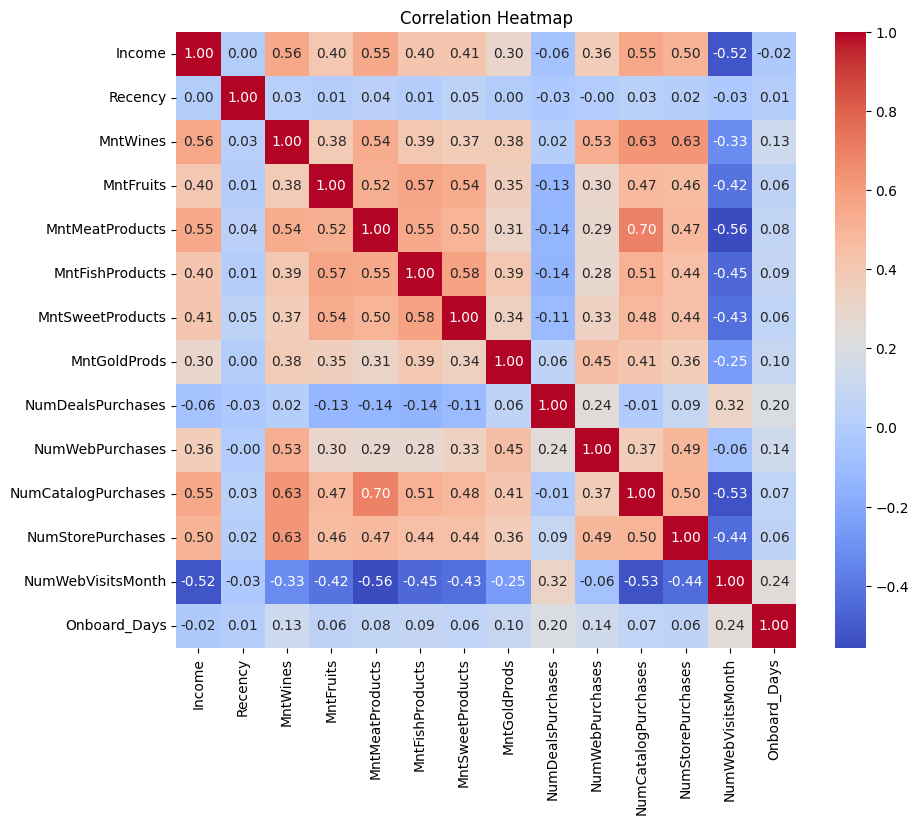

In [57]:
# Examining the correlation
def plot_corr(df):
    plt.figure(figsize=(10, 8))

    corr_matrix = df[num_ftrs_1].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    
plot_corr(df_train)

In [58]:
# Function to plot the distribution of numerical features
def dist_plot(df):        
        fig, axes = plt.subplots(4, 4, figsize=(8, 7))
        axes = axes.flatten()

        for i, var in enumerate(num_ftrs_1):
                sns.histplot(x=var, ax=axes[i], data=df, kde=True)
        axes[-1].axis('off')
        axes[-2].axis('off')
        plt.tight_layout()
        plt.show()

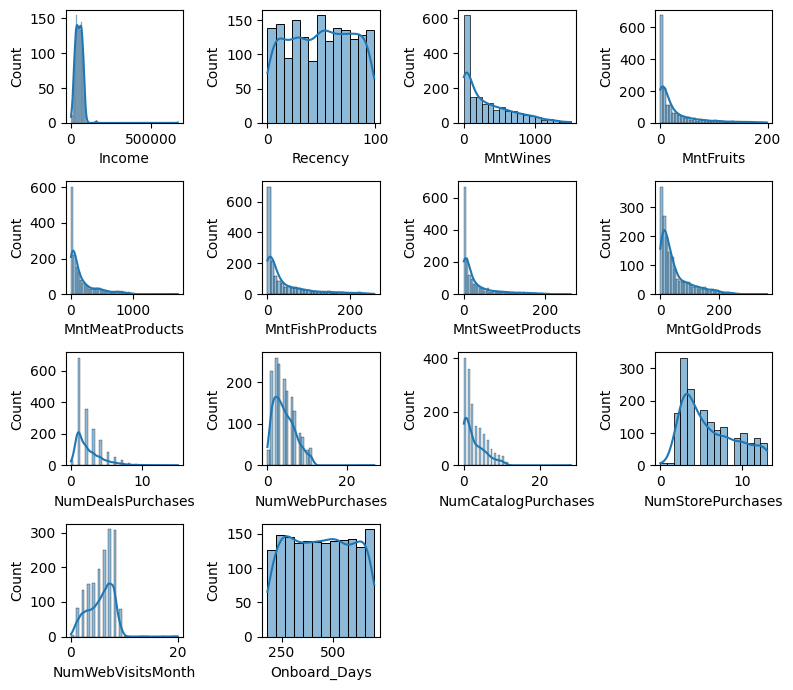

In [59]:
# Check for the distribution of numeric features
dist_plot(df_train)

In [60]:
# Numeric features transformation
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', PowerTransformer(method='yeo-johnson')),
])

# ColumnTransformer with numeric and categorical features transformers
ct = ColumnTransformer([
    ('num_trans', num_transformer, num_ftrs_1),
    ('cat_trans', SimpleImputer(strategy='most_frequent'), categ_ftrs_1)
])

# Create a DataFrame
df_train = pd.DataFrame(ct.fit_transform(df_train), 
                      columns=num_ftrs_1+categ_ftrs_1)

In [61]:
df_train.dtypes.to_frame().T

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Marital_Status,Kidhome,Teenhome,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group
0,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object


In [62]:
df_train[num_ftrs_1] = df_train[num_ftrs_1].astype('float')
df_train[categ_ftrs_1] = df_train[categ_ftrs_1].astype('str')

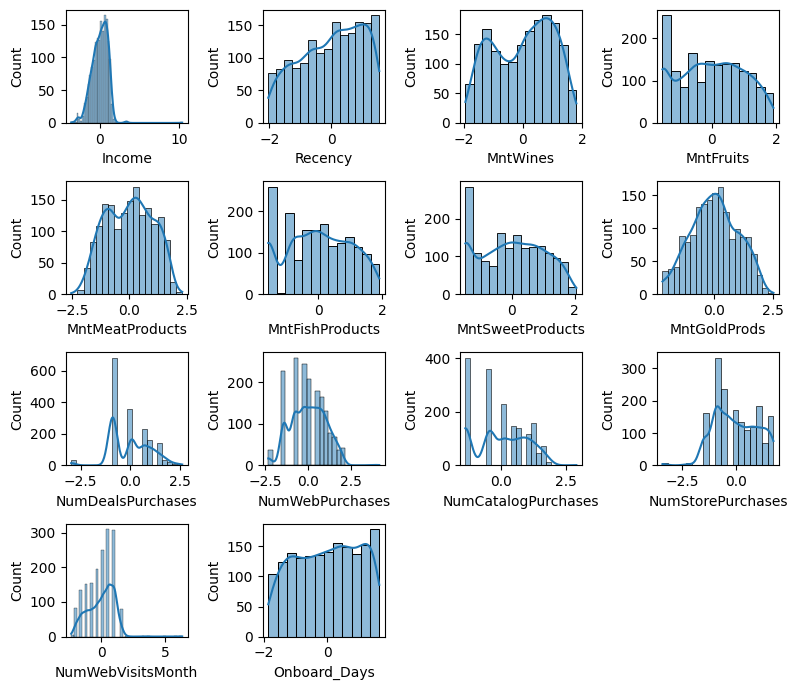

In [63]:
dist_plot(df_train)

## Part 2

In [64]:
# # Importing libraries

# import numpy as np
# import pandas as pd
# import seaborn as sns
# from datetime import datetime
# import matplotlib.pyplot as plt

# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import PowerTransformer
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.metrics import (roc_auc_score,
#                              confusion_matrix,
#                              classification_report)

In [65]:

dependants = ['Kidhome', 'Teenhome']

# assuming analysis was conducted in 2014 
now = 2014

# Define the bin edges
bins = [18, 28, 38, 48, 58, 65, np.inf]

# Define the labels for each age group
labels = ['18-27', '28-37', '38-47', '48-57', '58-65', '65+']

# End of financial year
end_fiscal = datetime(2014, 6, 30)

# Redundant features
red_ftrs_1 = ["ID", "Year_Birth", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Age", "Response"]

# List of categorical and numeric features
categ_ftrs_1 = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Age_Group']

num_ftrs_1 = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Onboard_Days']

In [66]:

def scrub_data(df):
    
    # Convert 'Kidhome' and 'Teenhome' to categorical
    # but first fillna with the most frequent value
    df[dependants] = df[dependants].fillna(df[dependants].mode().iloc[0])
    df[dependants] = df[dependants].applymap(lambda x: 1 if x > 0 else 0)
    
    # Conversions into 'datetime' data type
    # but first fillna in both variables
    df['Year_Birth'] = df['Year_Birth'].fillna(int(df['Year_Birth'].median()))
    df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format='%Y')
    
    df['Dt_Customer'] = df['Dt_Customer'].fillna(df['Dt_Customer'].mode().iloc[0])
    df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
    
    # Calculate age
    df['Age'] = now - df['Year_Birth'].dt.year
    
    # Create age group feature
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    # Calculate the number of days since customer enrolled
    df['Onboard_Days'] = (end_fiscal - df['Dt_Customer']).dt.days
    
    # Droping redundant features
    df = df.drop(red_ftrs_1, axis=1)
    
    # handle missing values and scale numeric data
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('normalize', PowerTransformer(method='yeo-johnson')),
    ])
    
    ct = ColumnTransformer([
        ('num_trans', num_transformer, num_ftrs_1),
        ('cat_trans', SimpleImputer(strategy='most_frequent'), categ_ftrs_1)
    ])
        
    df = pd.DataFrame(ct.fit_transform(df), 
                      columns=num_ftrs_1+categ_ftrs_1)
    
    # Ensure that the final df features are in the right data types
    df[categ_ftrs_1] = df[categ_ftrs_1].astype('str')
    df[num_ftrs_1] = df[num_ftrs_1].astype('float')
    
    
    return df

In [67]:
# Clean and preprocess the data ones
train_data = scrub_data(df_train_2)
val_data = scrub_data(df_val)

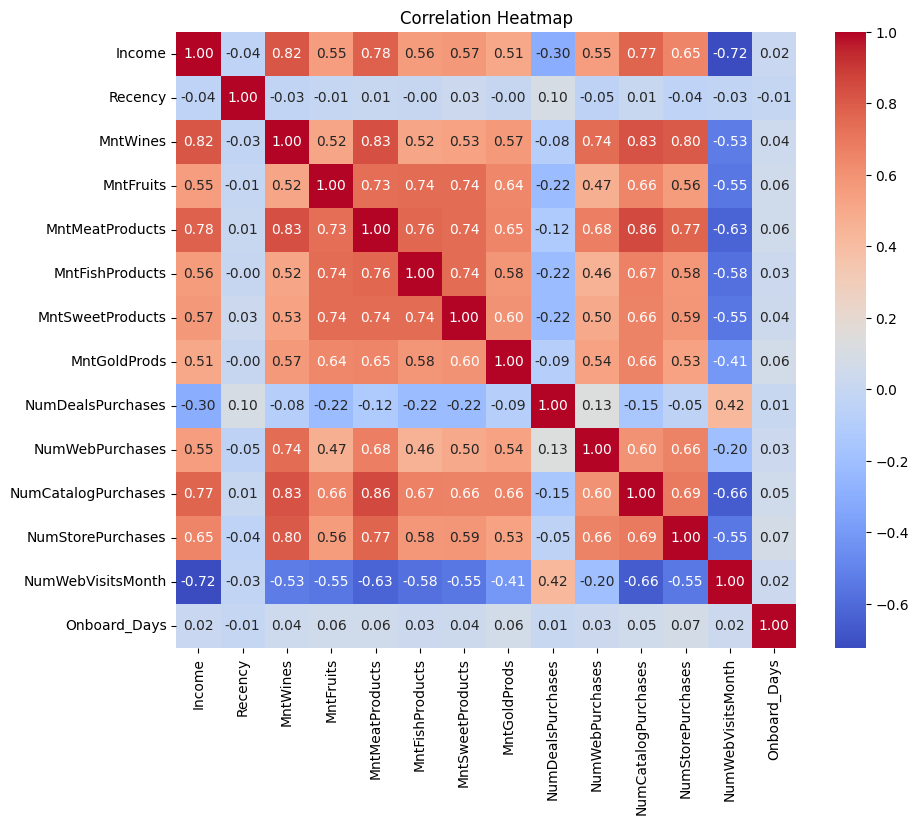

In [68]:
# Check correlation of numeric features
plot_corr(val_data)

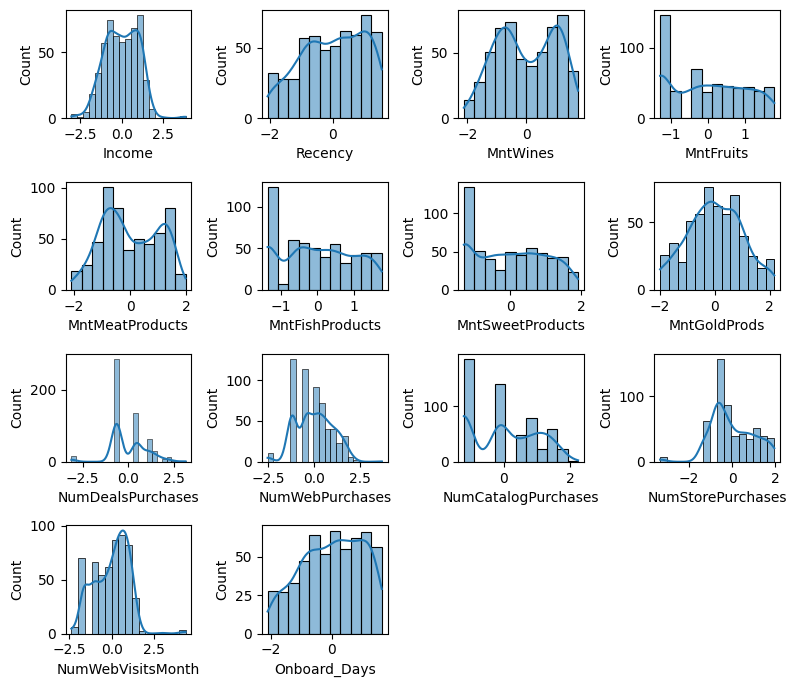

In [69]:
# Check distribution of numerical features
dist_plot(val_data)

## Training Model

In [70]:
# From DataFrame to dictionary
train_dicts= train_data.to_dict(orient='records')
val_dicts = val_data.to_dict(orient='records')

In [71]:
# Use dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [72]:
# Define a function that outputs relevant metrics

def metrics_output(X_1, X_2, y_1, y_2, clf):
    """Generate relevant classification metrics

    Args:
        X_1: X_train
        X_2: X_val or X_train if testing model performance on training data
        y_1: y_train
        y_2: y_val or y_train if testing model performance on training data
        clf: classifier
    """
    
    # Fit classifier
    clf.fit(X_1, y_1)
    
    # Get prediction
    y_pred_class = clf.predict(X_2)
    
    # Create confusion matrix table
    cols = pd.MultiIndex.from_tuples(
        [('predictions', 0), ('predictions', 1)]
    )
    indx = pd.MultiIndex.from_tuples(
        [('actual', 0), ('actual', 1)]
    )
    cmat = confusion_matrix(y_2, y_pred_class)
    display(pd.DataFrame(cmat, columns=cols, index=indx))
    
    print('-'*50, '\n')

    # Print classification report
    print(classification_report(y_2, y_pred_class))
    
    print('-'*50)

In [73]:
lr = LogisticRegression(max_iter=300, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, lr)

predictions     
                   0    1
actual 0         386  123
       1           1   47

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       509
           1       0.28      0.98      0.43        48

    accuracy                           0.78       557
   macro avg       0.64      0.87      0.65       557
weighted avg       0.94      0.78      0.82       557

--------------------------------------------------


In [74]:
svc = SVC(random_state=2, probability=True, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, svc)

predictions    
                   0   1
actual 0         413  96
       1           1  47

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       509
           1       0.33      0.98      0.49        48

    accuracy                           0.83       557
   macro avg       0.66      0.90      0.69       557
weighted avg       0.94      0.83      0.86       557

--------------------------------------------------


In [75]:
rfc = RandomForestClassifier(random_state=2, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, rfc)

predictions    
                   0   1
actual 0         482  27
       1          27  21

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       509
           1       0.44      0.44      0.44        48

    accuracy                           0.90       557
   macro avg       0.69      0.69      0.69       557
weighted avg       0.90      0.90      0.90       557

--------------------------------------------------


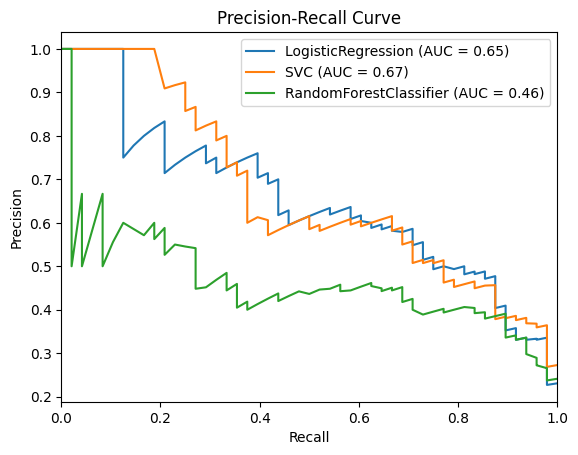

In [76]:
models = [lr, svc, rfc]
 
# Train the models and calculate precision-recall values

results = []
for model in models:
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, probs)
    results.append((model.__class__.__name__, precision, recall))

# Create a single plot for Precision-Recall curves
fig, ax = plt.subplots()
for name, precision, recall in results:
    auc_score = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUC = {auc_score:.2f})")

plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
